# Clustering Analysis of Spotify Data

This notebook performs clustering analysis on the Spotify numerical features dataset using:
1. KMeans clustering with elbow method and silhouette analysis
2. DBSCAN clustering
3. Comparison and final cluster assignments

In [43]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

## 1. Data Loading and Scaling

In [48]:
# Load the data
print("Loading data...")
df = pd.read_csv('../data/5_spotify_numerical.csv')

# Filter for genres with at least 40 entries
genre_counts = df.sum()
popular_genres = genre_counts[genre_counts >= 30].index
df = df[popular_genres]

print("Shape of the dataset:", df.shape)
df.head()

Loading data...
Shape of the dataset: (9991, 226)


,release_date,popularity,duration_ms,explicit,abstract hip hop,acoustic blues,adult standards,album rock,alternative dance,alternative hip hop,...,urban contemporary,velha guarda,viking metal,vintage chanson,vocal jazz,west coast rap,western swing,yacht rock,ye ye,zolo
0,2008,14,150040,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2004,1,253000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,3,240400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2007,1,138760,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,0,199986,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Scale the data and save scaler for later use
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
print("Data has been scaled using StandardScaler")

# Save scaler for later reuse
import pickle
with open('../scaler/spotify_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to '../scaler/spotify_scaler.pkl'")

Data has been scaled using StandardScaler
Scaler saved to '../scaler/spotify_scaler.pkl'


## 2. KMeans Clustering Analysis

In [67]:
# Perform elbow method and silhouette analysis
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 100)

for n_clusters in range_n_clusters:
    print(f"Testing {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate metrics
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg:.3f}")

Testing 2 clusters...
Silhouette score for 2 clusters: 0.319
Testing 3 clusters...
Silhouette score for 3 clusters: 0.266
Testing 4 clusters...
Silhouette score for 4 clusters: 0.227
Testing 5 clusters...
Silhouette score for 5 clusters: 0.232
Testing 6 clusters...
Silhouette score for 6 clusters: 0.239
Testing 7 clusters...
Silhouette score for 7 clusters: 0.245
Testing 8 clusters...
Silhouette score for 8 clusters: 0.230
Testing 9 clusters...
Silhouette score for 9 clusters: 0.248
Testing 10 clusters...
Silhouette score for 10 clusters: 0.253
Testing 11 clusters...
Silhouette score for 11 clusters: 0.258
Testing 12 clusters...
Silhouette score for 12 clusters: 0.263
Testing 13 clusters...
Silhouette score for 13 clusters: 0.269
Testing 14 clusters...
Silhouette score for 14 clusters: 0.273
Testing 15 clusters...
Silhouette score for 15 clusters: 0.277
Testing 16 clusters...
Silhouette score for 16 clusters: 0.282
Testing 17 clusters...
Silhouette score for 17 clusters: 0.284
Testing 

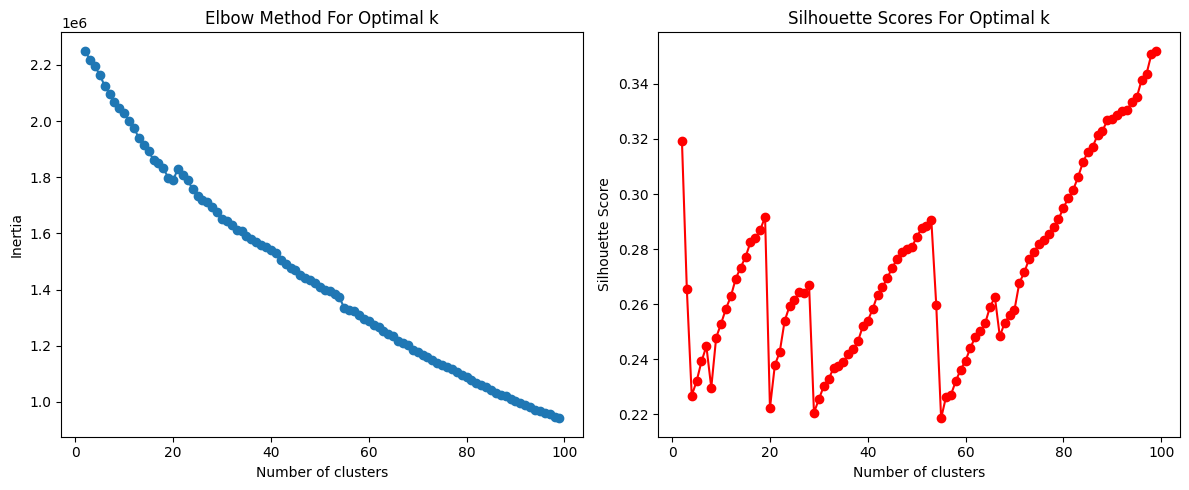

In [68]:
# Plot elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Scores For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [57]:
# Save scaled data to CSV
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.to_csv('../data/6_spotify_numerical_scaled.csv', index=False)



## 3. DBSCAN Clustering

In [52]:
# Try different DBSCAN parameters with wider range
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]  # Increased range
min_samples_values = [3, 5, 10]  # Lower minimum samples

best_silhouette = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nTesting DBSCAN with eps={eps}, min_samples={min_samples}")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data)
        
        # Count number of clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"Number of clusters found: {n_clusters}")
        print(f"Number of noise points: {n_noise}")
        
        # Only calculate silhouette score if there's more than one cluster and not all points are noise
        if n_clusters > 1:
            # Filter out noise points for silhouette score calculation
            mask = labels != -1
            if np.sum(mask) > 1:  # Make sure we have at least 2 points
                score = silhouette_score(scaled_data[mask], labels[mask])
                print(f"Silhouette score: {score:.3f}")
                
                if score > best_silhouette:
                    best_silhouette = score
                    best_params = (eps, min_samples)
        else:
            print("Invalid clustering result - no clear clusters found")

if best_params is not None:
    print(f"\nBest DBSCAN parameters: eps={best_params[0]}, min_samples={best_params[1]}")
    print(f"Best silhouette score: {best_silhouette:.3f}")
else:
    print("\nNo valid clustering results found. Try adjusting the parameter ranges.")
    print("Suggestions:")
    print("1. Increase the eps values range")
    print("2. Decrease the min_samples values")
    print("3. Check if your data is properly scaled")


Testing DBSCAN with eps=0.5, min_samples=3
Number of clusters found: 415
Number of noise points: 4043
Silhouette score: 0.491

Testing DBSCAN with eps=0.5, min_samples=5
Number of clusters found: 121
Number of noise points: 5126
Silhouette score: 0.571

Testing DBSCAN with eps=0.5, min_samples=10
Number of clusters found: 27
Number of noise points: 5973
Silhouette score: 0.657

Testing DBSCAN with eps=1.0, min_samples=3
Number of clusters found: 567
Number of noise points: 2129
Silhouette score: 0.707

Testing DBSCAN with eps=1.0, min_samples=5
Number of clusters found: 248
Number of noise points: 3300
Silhouette score: 0.732

Testing DBSCAN with eps=1.0, min_samples=10
Number of clusters found: 72
Number of noise points: 4666
Silhouette score: 0.709

Testing DBSCAN with eps=1.5, min_samples=3
Number of clusters found: 616
Number of noise points: 1225
Silhouette score: 0.743

Testing DBSCAN with eps=1.5, min_samples=5
Number of clusters found: 332
Number of noise points: 2293
Silhouet

## 4. Final Clustering and Save Results

In [53]:
# Choose the best method (KMeans or DBSCAN) based on silhouette scores
# For this example, we'll use KMeans with the optimal k
optimal_k = 7  # Update this based on your elbow method and silhouette analysis results

# Fit KMeans model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = final_kmeans.fit_predict(scaled_data)

# Fit DBSCAN model with best parameters
best_dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
dbscan_labels = best_dbscan.fit_predict(scaled_data)

# Save the models
import pickle
with open('../models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(final_kmeans, f)
with open('../models/dbscan_model.pkl', 'wb') as f:
    pickle.dump(best_dbscan, f)

# Save the results
df.to_csv('../data/7_clustered_dataset.csv', index=False)
print(f"Models saved as kmeans_model.pkl and dbscan_model.pkl")
print(f"Results saved to 7_clustered_dataset.csv")

# Display cluster distribution
print("\nKMeans cluster distribution:")
print(df['cluster'].value_counts())
print("\nDBSCAN cluster distribution:")
print(pd.Series(dbscan_labels).value_counts())


Models saved as kmeans_model.pkl and dbscan_model.pkl
Results saved to 7_clustered_dataset.csv

KMeans cluster distribution:
cluster
1    9341
0     216
3     189
4     123
6      47
5      39
2      36
Name: count, dtype: int64

DBSCAN cluster distribution:
 2      3628
-1       702
 3       213
 163      70
 136      60
        ... 
 639       3
 643       3
 645       3
 647       3
 648       3
Name: count, Length: 650, dtype: int64


In [54]:
df.cluster.unique()

array([1, 3, 4, 0, 2, 5, 6], dtype=int32)

In [58]:
# Get list of columns that were dropped
original_columns = pd.read_csv('../data/5_spotify_numerical.csv').columns
current_columns = df.columns
dropped_genres = [col for col in original_columns if col not in current_columns and col != 'cluster']

print("Genres that were removed during preprocessing:")
for genre in dropped_genres:
    print(f"- {genre}")



Genres that were removed during preprocessing:
- "childrens choir
- "childrens music
- "mans orchestra
- "punk n roll
- "womens music
- 21st century classical
- abstract
- accordeon
- accordion
- acid house
- acid jazz
- acid rock
- acid trance
- acousmatic
- acoustic pop
- acoustic rock
- african-american classical
- afro-cuban percussion
- afrobeat
- afrobeat fusion
- afrobeats
- afropop
- aggrotech
- alaska indie
- alberta country
- alternative americana
- alternative country
- alternative metalcore
- alternative pop
- alternative r&b
- alternative roots rock
- ambient
- ambient black metal
- ambient dub
- ambient idm
- ambient industrial
- ambient psychill
- ambient worship
- american choir
- american contemporary classical
- american folk revival
- american grindcore
- american metalcore
- american modern classical
- american oi
- american post-rock
- american romanticism
- amharic pop
- anthem emo
- anti-folk
- appalachian folk
- arab folk
- arab groove
- arab pop
- arabesk
- arg

In [65]:
# Load the original Spotify tracks dataset and the clustered data
original_df = pd.read_csv('../data/4_spotify_million_tracks.csv')
clustered_df = pd.read_csv('../data/7_clustered_dataset.csv')

# Ensure the datasets are aligned
assert len(original_df) == len(clustered_df), "Dataset lengths don't match!"

# Add cluster assignments to the original dataset
original_df['kmeans_cluster'] = clustered_df['cluster']
original_df['dbscan_cluster'] = dbscan_labels  # Using the labels from previous cell

# Extract year from release_date
original_df['release_date'] = original_df['release_date'].str.split('-').str[0]

# Select only the relevant columns for recommendations
columns_to_keep = [
    'original_title', 'original_artist', 'spotify_title', 'spotify_artist',
    'album', 'release_date', 'popularity', 'duration_ms', 'explicit',
    'album_cover', 'kmeans_cluster', 'dbscan_cluster'  # Added cluster columns
]

# Create the final dataset
final_df = original_df[columns_to_keep]

# Save the final dataset
final_df.to_csv('../data/8_spotify_million_tracks_clustered.csv', index=False)

# Display some information about the final dataset
print("Final dataset shape:", final_df.shape)
print("\nColumns in final dataset:")
print(final_df.columns.tolist())
print("\nSample of final dataset:")
print(final_df.head())
print("\nCluster distributions:")
print("\nKMeans clusters:")
print(final_df['kmeans_cluster'].value_counts())
print("\nDBSCAN clusters:")
print(final_df['dbscan_cluster'].value_counts().head())

Final dataset shape: (9991, 12)

Columns in final dataset:
['original_title', 'original_artist', 'spotify_title', 'spotify_artist', 'album', 'release_date', 'popularity', 'duration_ms', 'explicit', 'album_cover', 'kmeans_cluster', 'dbscan_cluster']

Sample of final dataset:
                   original_title         original_artist  \
0  Je Sais Que La Terre Est Plate                 Raphaël   
1                       On Efface           Julie Zenatti   
2                 Howells Delight   The Baltimore Consort   
3                   Martha Served            I Hate Sally   
4              Zip-A-Dee-Doo-Dah   Orlando Pops Orchestra   

                                  spotify_title          spotify_artist  \
0                Je sais que la Terre est plate                 Raphaël   
1                                     On efface           Julie Zenatti   
2                               Howells Delight               Anonymous   
3                                 Martha Served           

In [66]:
final_df.kmeans_cluster.unique()

array([1, 3, 4, 0, 2, 5, 6])